In [2]:
%matplotlib inline
import pyspeckit
import numpy as np
from astropy import units as u
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.convolution import convolve, Box1DKernel
from c_normalize import c_normalize
import glob
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
plt.style.use('seaborn-paper')

In [3]:
from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

# Python-based Automation of Equivalent Width Measurement
Utilizing pyspeckit (https://pyspeckit.readthedocs.io/en/latest/) and a python port of Joleen Carlberg's (STScI) Continuum Normalization algorithm, this notebook seeks to set up and test an automated equivalent width measurement algorithm for a number of spectrum for which we have hand measurements. The expectations for this method are that 95% of the measurements are within 5% of our by-hand measurements.

### An Example
Before diving straight into scripting, it's useful to layout an individual example of the equivalent width measurement process.

EQW: 141.2591185926145 mA


Text(0.5, 1.0, '5307.36')

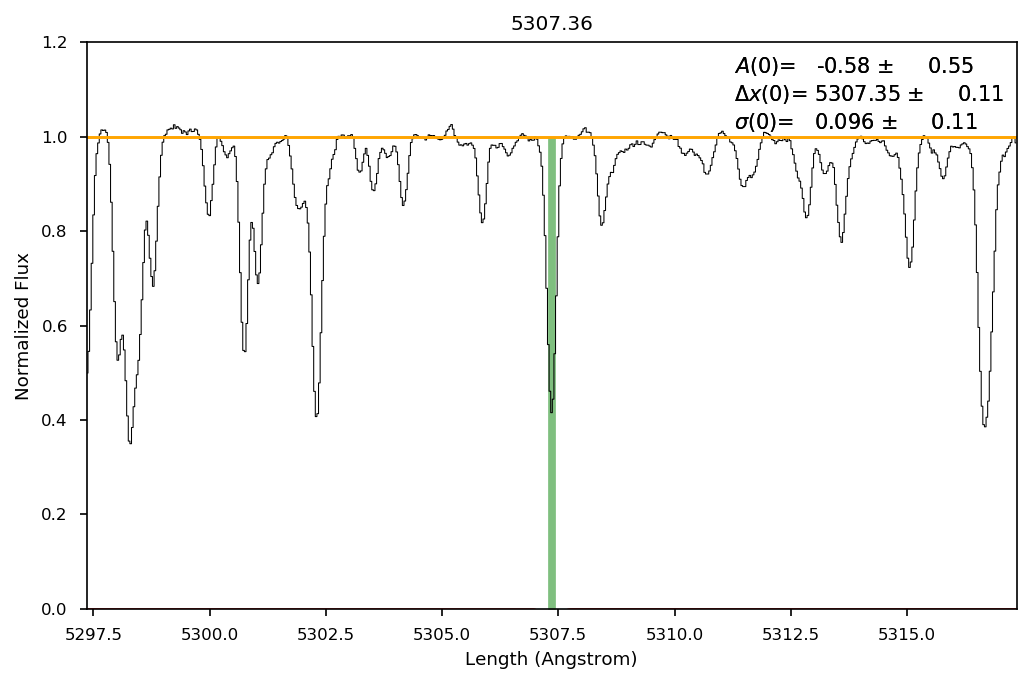

In [8]:
# Pull in an example spectrum
s_hdu = fits.open("Data/ew_known/tame_inputs/col110_1134red_oned_25jan14_wavsoln.fits")
fig = plt.figure(figsize=(8,5), dpi = 150)

# Grab the flux and wavelength arrays from the spectrum
s_data = s_hdu[1].data
s_flux = s_data['FLUX']
smoothed_flux = convolve(s_flux, Box1DKernel(5)) # Smooth the flux for more reliable continuum fitting
s_flux = smoothed_flux
s_wav = s_data['WAVEL']

# Specify up a specific line to measure the EQW for, and specify the wavelength range to sample for the local continuum
line_cen = 5307.36
width = 10
lim_l = line_cen - width
lim_r = line_cen + width

# Mask the flux and wavelength arrays based on the sampled wavelength range
wav_mask = (s_wav > lim_l) & (s_wav < lim_r)
s_flux = s_flux[wav_mask]
s_wav = s_wav[wav_mask]

# Normalize the spectrum with the local continuum to 1.0, c_normalize returns the normalized spectrum in norm, but also the local continuum fit in yfit if desired
yfit, norm, _ = c_normalize(s_flux, s_wav, median_replace=False, cheby=True, low_cut = 0.9)

# Load the normalized spectrum into a pyspeckit.Spectrum object
sp = pyspeckit.Spectrum(data=norm, xarr=s_wav * u.AA)
sp.plotter(figure = fig, xmin=lim_l, xmax=lim_r, ymin=0, ymax=1.2)

#Get around pyspeckits reliance on a generated baseline and just generate basespec as a ones array (continuum is always one in normalized case)
sp.baseline.basespec = np.ones(len(s_wav))

#Fit a gaussian to the line, this may be too simplistic for blended lines
sp.specfit(fittype='gaussian', guesses = [0.1, line_cen, 0.1])

#Measure the Equivalent Width of the gaussian line fit against the normalized baseline
EQW = sp.specfit.EQW(plot=True, continuum_as_baseline=True)
print("EQW:", EQW*1000*u.mA)
plt.axhline(1, color = 'orange')
plt.ylabel("Normalized Flux")
plt.title(str(line_cen))
#sp.plotter.savefig('basic_plot_example_withfit.png')

## Testing Consistency for a Line Across Multiple Spectrum
A crucial requirement for any automated equivalent width process is that it provides consistent results across the vast majority of spectrum for a given line.

In [4]:
# Select Datasets and extract equivalent widths
spectrum = glob.glob("data/ew_known/tame_inputs/*wavsoln.fits")
by_hand = glob.glob("tame-1.1.0/*.ew")
lc_range = np.arange(0.95,0.995,0.0001)
len_range = 10


d = {'Spectrum File': spectrum, 'By-Hand File': by_hand}
disp_df = pd.DataFrame(data=d)

data/ew_known/tame_inputs/ngc6583_50red_oned_slit07_jun14_wavsoln.fits
Python: 179.899889197 Hand: 169.7
=====
data/ew_known/tame_inputs/ngc6583_72red_oned_slit07_jun14_wavsoln.fits
Python: 175.239087857 Hand: 165.2
=====
Line Statistics
Percent Difference
Median Difference: 1.5105296120731564%
Standard Deviation of Difference: 2.525593324758902%
~95% within 5.05%


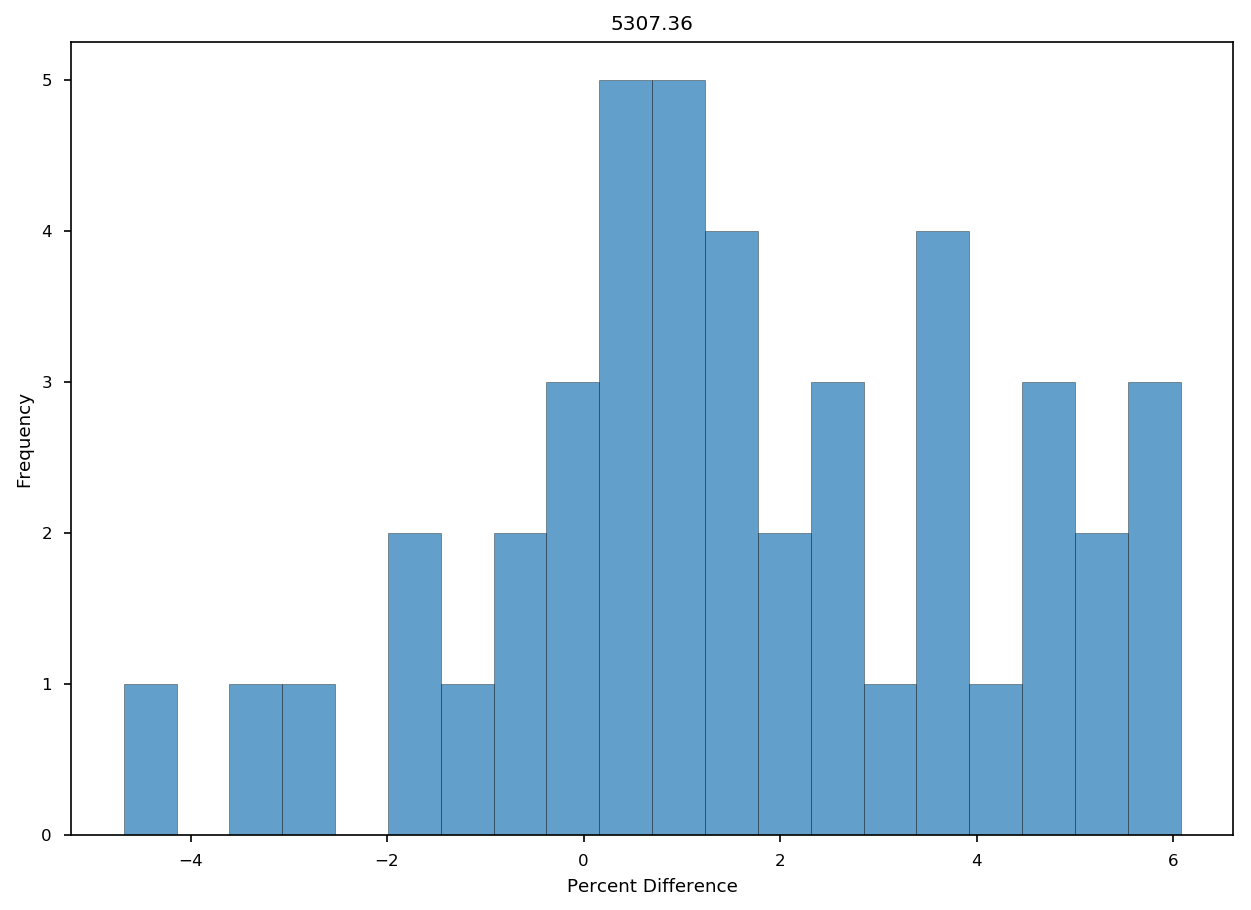

In [16]:
line = 5307.36
width = 10 #Distance from the line on both sides to sample the local continuum from
percent_difference = True
diff = []
for row in disp_df.iterrows():
    eqw_file, spec_file = row[1]
    eqw_df = pd.read_csv(eqw_file, header=None, delim_whitespace = True)
    if line not in eqw_df[0].tolist():
        print("Line Missing")
        continue
    mask = eqw_df[0] == line
    byhand_eqw = eqw_df[4][mask.tolist()].tolist()[0]
    if byhand_eqw == 0.:
        continue
    
    s_hdu = fits.open(spec_file)
    
    # Grab the flux and wavelength arrays from the spectrum
    s_data = s_hdu[1].data
    s_flux = s_data['FLUX']
    smoothed_flux = convolve(s_flux, Box1DKernel(5)) # Smooth the flux for more reliable continuum fitting
    s_flux = smoothed_flux
    s_wav = s_data['WAVEL']

    # Specify up a specific line to measure the EQW for, and specify the wavelength range to sample for the local continuum
    lim_l = line - width
    lim_r = line + width

    # Mask the flux and wavelength arrays based on the sampled wavelength range
    wav_mask = (s_wav > lim_l) & (s_wav < lim_r)
    s_flux = s_flux[wav_mask]
    s_wav = s_wav[wav_mask]

    # Normalize the spectrum with the local continuum to 1.0, c_normalize returns the normalized spectrum in norm, but also the local continuum fit in yfit if desired
    yfit, norm, _ = c_normalize(s_flux, s_wav, median_replace=False, cheby=True, low_cut = 0.99)
    # Load the normalized spectrum into a pyspeckit.Spectrum object
    sp = pyspeckit.Spectrum(data=norm, xarr=s_wav * u.AA)

    #Get around pyspeckits reliance on a generated baseline and just generate basespec as a ones array (continuum is always one in normalized case)
    sp.baseline.basespec = np.ones(len(s_wav))

    #Fit a gaussian to the line, this may be too simplistic for blended lines
    with suppress_stdout(): #Suppress some annoying info messages that don't translate well to automation
        sp.specfit(fittype='gaussian', guesses = [20, line, 0.15], exclude= [0,line-0.2, line+0.2, line+5000])

    #Measure the Equivalent Width of the gaussian line fit against the normalized baseline
    EQW = sp.specfit.EQW(plot=False, continuum_as_baseline=True, xmin = 0, xmax = len(norm))
    EQW = EQW*1000 #mA
    #print("EQW:", EQW*1000*u.mA)
    #print(abs(EQW-byhand_eqw), byhand_eqw)
    if abs(EQW - byhand_eqw) > 10:
        print (spec_file)
        print("Python: "+str(EQW), "Hand: "+str(byhand_eqw))
        print("=====")
    if percent_difference:
        diff.append(((EQW-byhand_eqw)/byhand_eqw) * 100) #Percent Difference
    else:
        diff.append(EQW-byhand_eqw) #mA Difference
fig = plt.figure(figsize=(10,7), dpi = 150)
plt.hist(diff,histtype='bar',ec='black',alpha=0.7,color = plt.cm.tab20(0),bins=20)
plt.ylabel("Frequency")
if percent_difference:
    plt.xlabel("Percent Difference")
else:
        plt.xlabel("mA Difference")
plt.title(line)
print("Line Statistics")
print("===============")
if percent_difference:
    print("Percent Difference")
    symbol = "%"
else:
    print("mA Difference")
    symbol = " mA"
print("Median Difference: {}{}".format(np.median(diff),symbol))
print("Standard Deviation of Difference: {}{}".format(np.std(diff), symbol))
print("~95% within {}{}".format(np.round(2*np.std(diff), 2), symbol))
    


data/ew_known/tame_inputs/col110_2119red_oned_26jan14_wavsoln.fits
Python: 73.30621540386329 Hand: 84.3
=====
data/ew_known/tame_inputs/col110_2129red_oned_25jan14_wavsoln.fits
Python: 94.50976914623865 Hand: 83.4
=====
data/ew_known/tame_inputs/col110_3122red_oned_mar2014_wavsoln.fits
Python: 93.41365030747006 Hand: 76.4
=====
data/ew_known/tame_inputs/col110_3144red_oned_mar2014_wavsoln.fits
Python: 100.0399075858116 Hand: 88.2
=====
data/ew_known/tame_inputs/col110_3244red_oned_25jan14_wavsoln.fits
Python: 93.62682700945157 Hand: 78.1
=====
data/ew_known/tame_inputs/col110_4260red_oned_26jan14_wavsoln.fits
Python: 96.29899915069018 Hand: 82.2
=====
data/ew_known/tame_inputs/ngc2204_5352red_oned_05jan14_wavsoln.fits
Python: 83.8630216048335 Hand: 73.6
=====
data/ew_known/tame_inputs/ngc2506_4138red_oned_26jan14_wavsoln.fits
Python: 86.73104512023677 Hand: 75.6
=====
data/ew_known/tame_inputs/ngc2506_4205red_oned_25jan14_wavsoln.fits
Python: 88.39663632081773 Hand: 77.1
=====
data/ew_

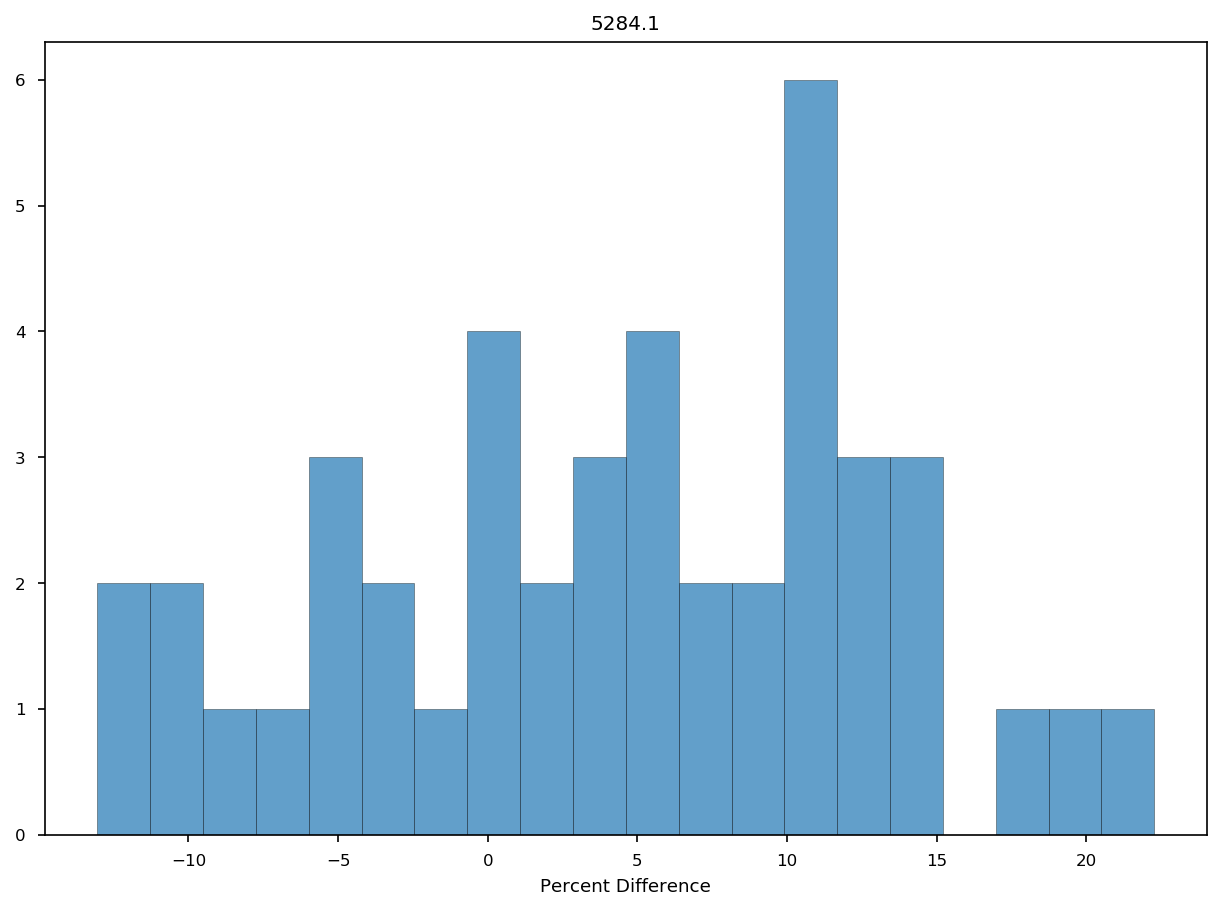

In [59]:
line = 5284.1 #5307.36
width = 10 #Distance from the line on both sides to sample the local continuum from
percent_difference = True

diff = []
for row in disp_df.iterrows():
    eqw_file, spec_file = row[1]
    eqw_df = pd.read_csv(eqw_file, header=None, delim_whitespace = True)
    if line not in eqw_df[0].tolist():
        print("Line Missing")
        continue
    mask = eqw_df[0] == line
    byhand_eqw = eqw_df[4][mask.tolist()].tolist()[0]
    if byhand_eqw == 0.:
        continue
    
    s_hdu = fits.open(spec_file)
    
    # Grab the flux and wavelength arrays from the spectrum
    s_data = s_hdu[1].data
    s_flux = s_data['FLUX']
    #smoothed_flux = convolve(s_flux, Box1DKernel(5)) # Smooth the flux for more reliable continuum fitting
    #s_flux = smoothed_flux
    s_wav = s_data['WAVEL']

    # Specify up a specific line to measure the EQW for, and specify the wavelength range to sample for the local continuum
    lim_l = line - width
    lim_r = line + width

    # Mask the flux and wavelength arrays based on the sampled wavelength range
    wav_mask = (s_wav > lim_l) & (s_wav < lim_r)
    s_flux = s_flux[wav_mask]
    s_wav = s_wav[wav_mask]

    # Normalize the spectrum with the local continuum to 1.0, c_normalize returns the normalized spectrum in norm, but also the local continuum fit in yfit if desired
    yfit, norm, _ = c_normalize(s_flux, s_wav, median_replace=False, cheby=True, low_cut = 0.99)
    # Load the normalized spectrum into a pyspeckit.Spectrum object
    sp = pyspeckit.Spectrum(data=norm, xarr=s_wav * u.AA)

    #Get around pyspeckits reliance on a generated baseline and just generate basespec as a ones array (continuum is always one in normalized case)
    sp.baseline.basespec = np.ones(len(s_wav))

    #Fit a gaussian to the line, this may be too simplistic for blended lines
    with suppress_stdout(): #Suppress some annoying info messages that don't translate well to automation
        sp.specfit(fittype='gaussian', guesses = [-0.3, line, 0.15, -0.7, line-0.3, 0.15, -0.3, line+0.2, 0.15], exclude= [0,line-1, line+0.4, line+5000])

    #Measure the Equivalent Width of the gaussian line fit against the normalized baseline
    EQW = sp.specfit.EQW(plot=False, continuum_as_baseline=True, xmin=0,xmax=len(norm), components=True)
    EQW = EQW[0]*1000 #mA
    #print("EQW:", EQW*1000*u.mA)
    #print(abs(EQW-byhand_eqw), byhand_eqw)
    if abs(EQW - byhand_eqw) > 10:
        print (spec_file)
        print("Python: "+str(EQW), "Hand: "+str(byhand_eqw))
        print("=====")
    if percent_difference:
        diff.append(((EQW-byhand_eqw)/byhand_eqw) * 100) #Percent Difference
    else:
        diff.append(EQW-byhand_eqw) #mA Difference
fig = plt.figure(figsize=(10,7), dpi = 150)
plt.hist(diff,histtype='bar',ec='black',alpha=0.7,color = plt.cm.tab20(0),bins=20)
plt.title(line)
if percent_difference:
    plt.xlabel("Percent Difference")
else:
        plt.xlabel("mA Difference")
plt.title(line)
print("Line Statistics")
print("===============")
if percent_difference:
    print("Percent Difference")
    symbol = "%"
else:
    print("mA Difference")
    symbol = " mA"
print("Median Difference: {}{}".format(np.median(diff),symbol))
print("Standard Deviation of Difference: {}{}".format(np.std(diff), symbol))
print("~95% within {}{}".format(np.round(2*np.std(diff), 2), symbol))
    


data/ew_known/tame_inputs/ngc2204_1212red_oned_06jan14_wavsoln.fits
Python: 231.2339591982493 Hand: 184.0
=====
data/ew_known/tame_inputs/ngc2204_1330red_oned_06jan14_wavsoln.fits
Python: 218.2435775761249 Hand: 197.9
=====
data/ew_known/tame_inputs/ngc2204_2212red_oned_05jan14_wavsoln.fits
Python: 290.0748242796016 Hand: 266.6
=====
data/ew_known/tame_inputs/ngc2204_3321red_oned_05jan14_wavsoln.fits
Python: 309.88200606719477 Hand: 284.2
=====
data/ew_known/tame_inputs/ngc2204_4223red_oned_05jan14_wavsoln.fits
Python: 288.51193775199846 Hand: 272.0
=====
data/ew_known/tame_inputs/ngc2204_4303red_oned_05jan14_wavsoln.fits
Python: 281.72181840963265 Hand: 269.6
=====
data/ew_known/tame_inputs/ngc2204_5352red_oned_05jan14_wavsoln.fits
Python: 284.17474887433514 Hand: 263.5
=====
data/ew_known/tame_inputs/ngc2204_6330red_oned_05jan14_wavsoln.fits
Python: 273.59625697270576 Hand: 260.9
=====
data/ew_known/tame_inputs/ngc2506_2380red_oned_26jan14_wavsoln.fits
Python: 100.49062797260876 Hand

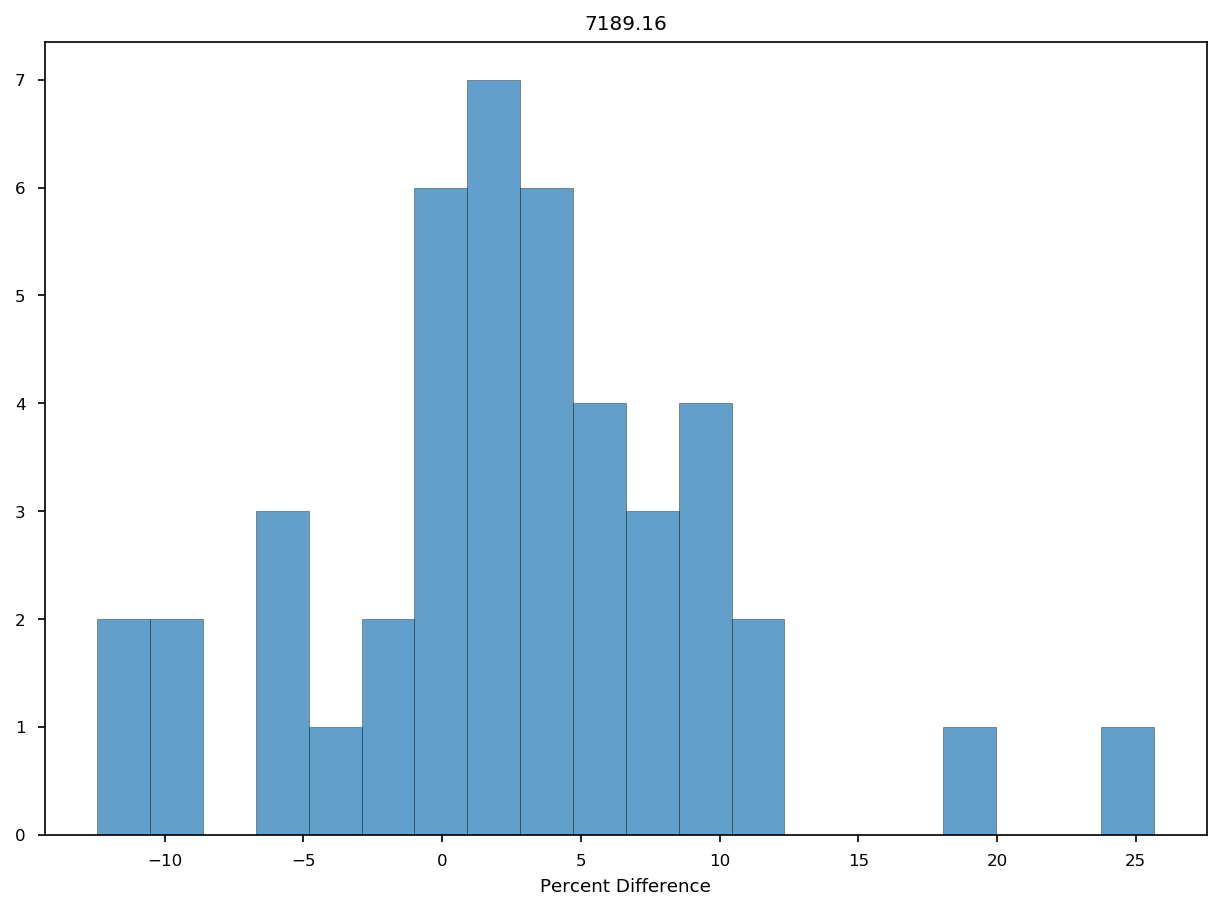

In [61]:
line = 7189.16 #5307.36
width = 10 #Distance from the line on both sides to sample the local continuum from
percent_difference = True

diff = []
for row in disp_df.iterrows():
    eqw_file, spec_file = row[1]
    eqw_df = pd.read_csv(eqw_file, header=None, delim_whitespace = True)
    if line not in eqw_df[0].tolist():
        print("Line Missing")
        continue
    mask = eqw_df[0] == line
    byhand_eqw = eqw_df[4][mask.tolist()].tolist()[0]
    if byhand_eqw == 0.0:
        continue
    
    s_hdu = fits.open(spec_file)
    
    # Grab the flux and wavelength arrays from the spectrum
    s_data = s_hdu[1].data
    s_flux = s_data['FLUX']
    #smoothed_flux = convolve(s_flux, Box1DKernel(5)) # Smooth the flux for more reliable continuum fitting
    #smoothed_flux = s_flux
    #s_flux = smoothed_flux
    s_wav = s_data['WAVEL']

    # Specify up a specific line to measure the EQW for, and specify the wavelength range to sample for the local continuum
    lim_l = line - width
    lim_r = line + width

    # Mask the flux and wavelength arrays based on the sampled wavelength range
    wav_mask = (s_wav > lim_l) & (s_wav < lim_r)
    s_flux = s_flux[wav_mask]
    s_wav = s_wav[wav_mask]

    # Normalize the spectrum with the local continuum to 1.0, c_normalize returns the normalized spectrum in norm, but also the local continuum fit in yfit if desired
    yfit, norm, _ = c_normalize(s_flux, s_wav, median_replace=False, cheby=True, low_cut = 0.99)
    # Load the normalized spectrum into a pyspeckit.Spectrum object
    sp = pyspeckit.Spectrum(data=norm, xarr=s_wav * u.AA)


    #Get around pyspeckits reliance on a generated baseline and just generate basespec as a ones array (continuum is always one in normalized case)
    sp.baseline.basespec = np.ones(len(s_wav))
    
    #Fit a gaussian to the line, this may be too simplistic for blended lines
    with suppress_stdout(): #Suppress some annoying info messages that don't translate well to automation
        sp.specfit(fittype='gaussian', guesses = [-0.3, line, 0.15], exclude= [0,line-0.23, line+0.1, line+50000])
    #print(sp.specfit.parinfo)

    #Measure the Equivalent Width of the gaussian line fit against the normalized baseline
    EQW = sp.specfit.EQW(plot=False, continuum_as_baseline=True, xmin=0, xmax=len(norm),components=True)
    EQW = np.array(EQW)*1000 #mA
    EQW = EQW[0]
    #print("EQW:", EQW*1000*u.mA)
    #print(abs(EQW-byhand_eqw), byhand_eqw)
    if abs(EQW - byhand_eqw) > 10:
        print (spec_file)
        print("Python: "+str(EQW), "Hand: "+str(byhand_eqw))
        print("=====")
    if percent_difference:
        diff.append(((EQW-byhand_eqw)/byhand_eqw) * 100) #Percent Difference
    else:
        diff.append(EQW-byhand_eqw) #mA Difference
fig = plt.figure(figsize=(10,7), dpi = 150)
plt.hist(diff,histtype='bar',ec='black',alpha=0.7,color = plt.cm.tab20(0),bins=20)
plt.title(line)
if percent_difference:
    plt.xlabel("Percent Difference")
else:
        plt.xlabel("mA Difference")
plt.title(line)
print("Line Statistics")
print("===============")
if percent_difference:
    print("Percent Difference")
    symbol = "%"
else:
    print("mA Difference")
    symbol = " mA"
print("Median Difference: {}{}".format(np.median(diff),symbol))
print("Standard Deviation of Difference: {}{}".format(np.std(diff), symbol))
print("~95% within {}{}".format(np.round(2*np.std(diff), 2), symbol))

data/ew_known/tame_inputs/col110_2119red_oned_26jan14_wavsoln.fits
Python: 101.14861787181617 Hand: 89.9
=====
data/ew_known/tame_inputs/ngc2204_6330red_oned_05jan14_wavsoln.fits
Python: 123.41796819169559 Hand: 113.0
=====
data/ew_known/tame_inputs/ngc2506_4138red_oned_26jan14_wavsoln.fits
Python: 111.82946545501515 Hand: 101.8
=====
data/ew_known/tame_inputs/ngc6583_39red_oned_slit07_jun14_wavsoln.fits
Python: 130.56772364262858 Hand: 146.7
=====
Line Statistics
Percent Difference
Median Difference: 2.3733899180471076%
Standard Deviation of Difference: 4.430701515304859%
~95% within 8.86%


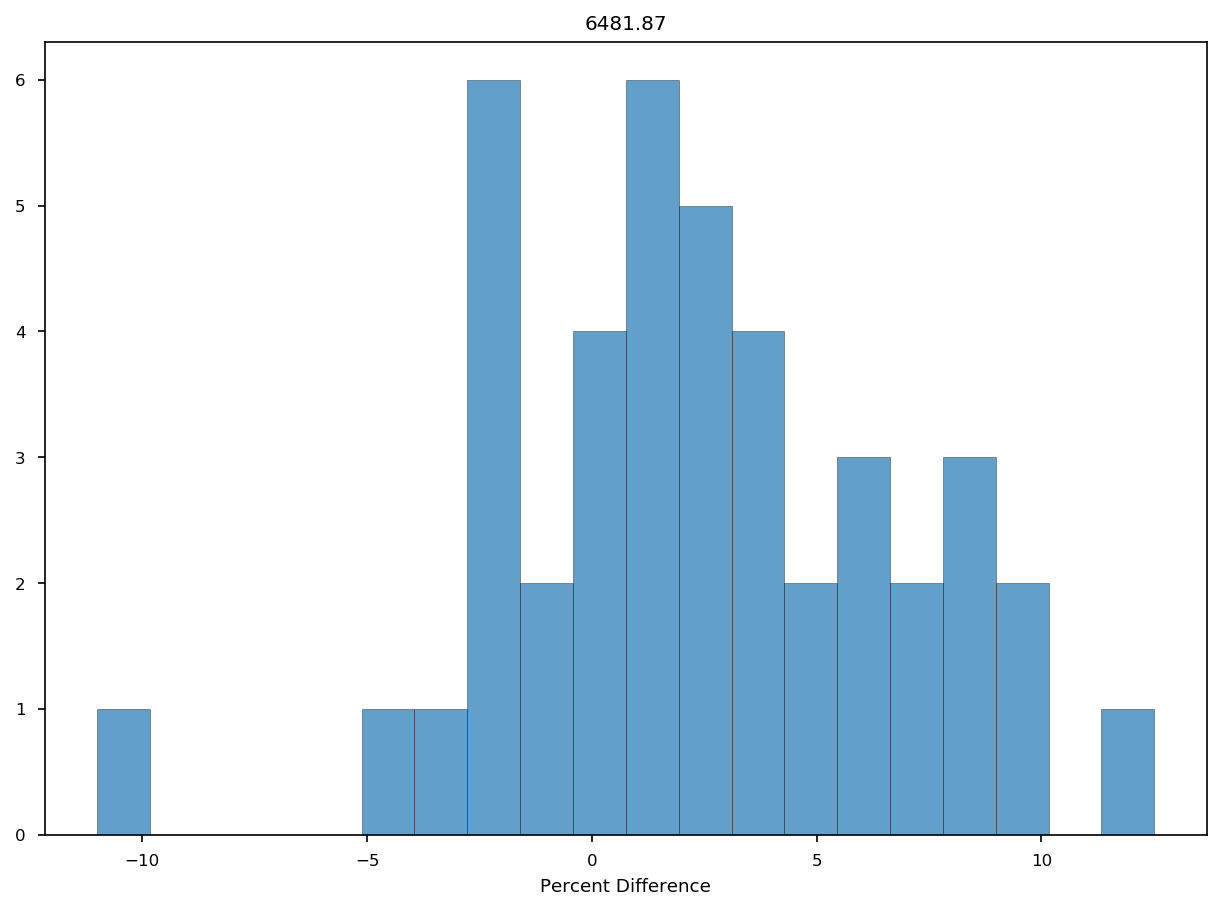

In [50]:
line = 6481.87 #5307.36
width = 10 #Distance from the line on both sides to sample the local continuum from
percent_difference = True

diff = []
for row in disp_df.iterrows():
    eqw_file, spec_file = row[1]
    eqw_df = pd.read_csv(eqw_file, header=None, delim_whitespace = True)
    if line not in eqw_df[0].tolist():
        print("Line Missing")
        continue
    mask = eqw_df[0] == line
    byhand_eqw = eqw_df[4][mask.tolist()].tolist()[0]
    if byhand_eqw == 0.0:
        continue
    
    s_hdu = fits.open(spec_file)
    
    # Grab the flux and wavelength arrays from the spectrum
    s_data = s_hdu[1].data
    s_flux = s_data['FLUX']
    #smoothed_flux = convolve(s_flux, Box1DKernel(5)) # Smooth the flux for more reliable continuum fitting
    #smoothed_flux = s_flux
    #s_flux = smoothed_flux
    s_wav = s_data['WAVEL']

    # Specify up a specific line to measure the EQW for, and specify the wavelength range to sample for the local continuum
    lim_l = line - width
    lim_r = line + width

    # Mask the flux and wavelength arrays based on the sampled wavelength range
    wav_mask = (s_wav > lim_l) & (s_wav < lim_r)
    s_flux = s_flux[wav_mask]
    s_wav = s_wav[wav_mask]

    # Normalize the spectrum with the local continuum to 1.0, c_normalize returns the normalized spectrum in norm, but also the local continuum fit in yfit if desired
    yfit, norm, _ = c_normalize(s_flux, s_wav, median_replace=False, cheby=True, low_cut = 0.99)
    # Load the normalized spectrum into a pyspeckit.Spectrum object
    sp = pyspeckit.Spectrum(data=norm, xarr=s_wav * u.AA)


    #Get around pyspeckits reliance on a generated baseline and just generate basespec as a ones array (continuum is always one in normalized case)
    sp.baseline.basespec = np.ones(len(s_wav))
    
    #Fit a gaussian to the line, this may be too simplistic for blended lines
    with suppress_stdout(): #Suppress some annoying info messages that don't translate well to automation
        sp.specfit(fittype='gaussian', guesses = [-0.3, line, 0.15], exclude= [0,line-0.2, line+0.13, line+5000])
    #print(sp.specfit.parinfo)

    #Measure the Equivalent Width of the gaussian line fit against the normalized baseline
    EQW = sp.specfit.EQW(plot=False, continuum_as_baseline=True, xmin=0, xmax=len(norm), components = True)
    EQW = np.array(EQW)*1000 #mA
    EQW = EQW[0]
    #print("EQW:", EQW*1000*u.mA)
    #print(abs(EQW-byhand_eqw), byhand_eqw)
    if abs(EQW - byhand_eqw) > 10:
        print (spec_file)
        print("Python: "+str(EQW), "Hand: "+str(byhand_eqw))
        print("=====")
    if percent_difference:
        diff.append(((EQW-byhand_eqw)/byhand_eqw) * 100) #Percent Difference
    else:
        diff.append(EQW-byhand_eqw) #mA Difference
fig = plt.figure(figsize=(10,7), dpi = 150)
plt.hist(diff,histtype='bar',ec='black',alpha=0.7,color = plt.cm.tab20(0),bins=20)
plt.title(line)
if percent_difference:
    plt.xlabel("Percent Difference")
else:
        plt.xlabel("mA Difference")
plt.title(line)
print("Line Statistics")
print("===============")
if percent_difference:
    print("Percent Difference")
    symbol = "%"
else:
    print("mA Difference")
    symbol = " mA"
print("Median Difference: {}{}".format(np.median(diff),symbol))
print("Standard Deviation of Difference: {}{}".format(np.std(diff), symbol))
print("~95% within {}{}".format(np.round(2*np.std(diff), 2), symbol))

data/ew_known/tame_inputs/col110_3122red_oned_mar2014_wavsoln.fits
Python: 78.46604147466074 Hand: 65.8
=====
data/ew_known/tame_inputs/col110_3144red_oned_mar2014_wavsoln.fits
Python: 77.19999837670954 Hand: 64.0
=====
data/ew_known/tame_inputs/col110_4260red_oned_26jan14_wavsoln.fits
Python: 67.13005683941198 Hand: 59.95
=====
data/ew_known/tame_inputs/ngc2204_2212red_oned_05jan14_wavsoln.fits
Python: 75.67387175028983 Hand: 67.5
=====
data/ew_known/tame_inputs/ngc2204_3205red_oned_06jan14_wavsoln.fits
Python: 58.08911249804449 Hand: 51.4
=====
data/ew_known/tame_inputs/ngc2204_4115red_oned_06jan14_wavsoln.fits
Python: 63.1798890348052 Hand: 56.7
=====
data/ew_known/tame_inputs/ngc2204_4119red_oned_06jan14_wavsoln.fits
Python: 59.395414049352446 Hand: 53.4
=====
data/ew_known/tame_inputs/ngc2204_4223red_oned_05jan14_wavsoln.fits
Python: 54.26825666679935 Hand: 63.2
=====
data/ew_known/tame_inputs/ngc2204_5352red_oned_05jan14_wavsoln.fits
Python: 59.17239855563139 Hand: 50.1
=====
dat

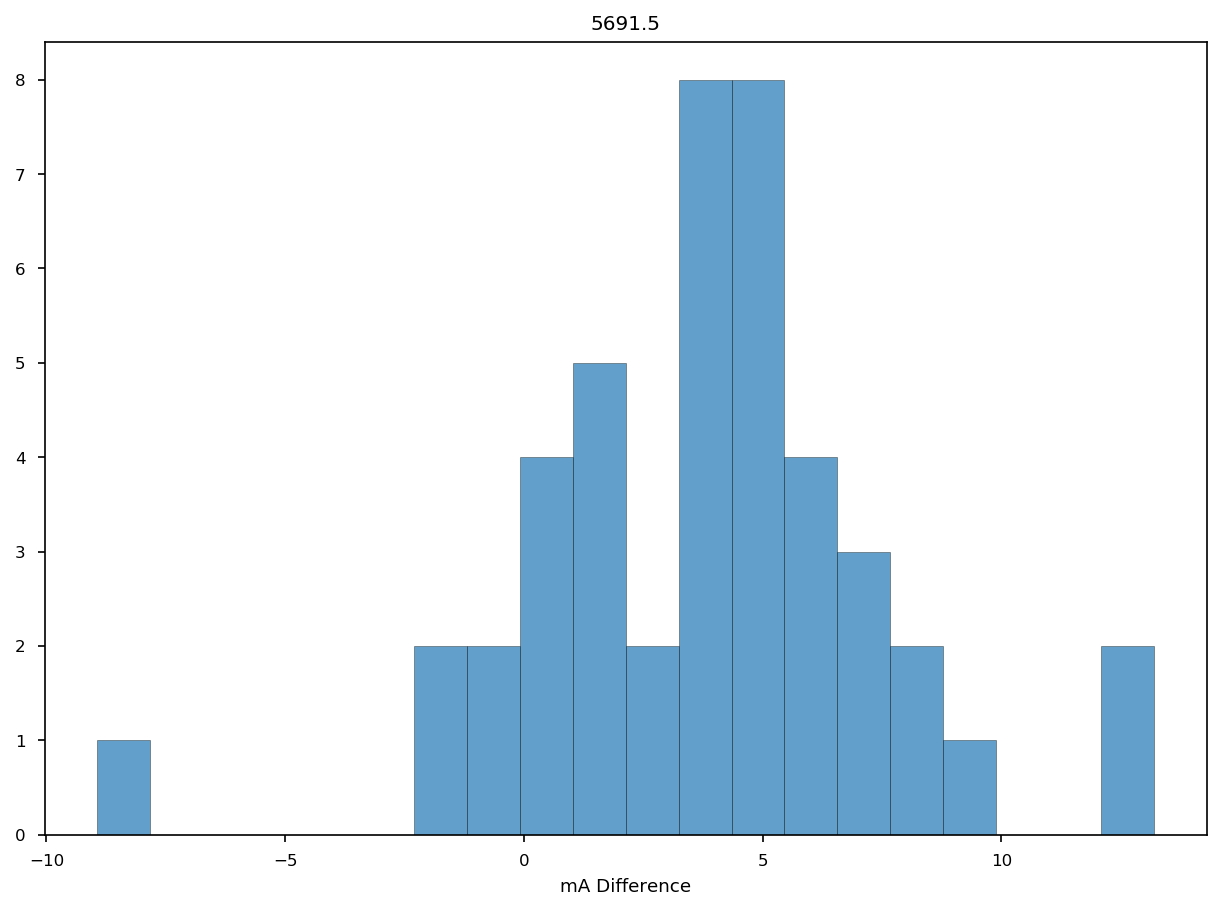

In [34]:
line_cen = 5691.5 #5307.36
width = 10 #Distance from the line on both sides to sample the local continuum from
percent_difference = False

diff = []
for row in disp_df.iterrows():
    eqw_file, spec_file = row[1]
    eqw_df = pd.read_csv(eqw_file, header=None, delim_whitespace = True)
    if line_cen not in eqw_df[0].tolist():
        print("Line Missing")
        continue
    mask = eqw_df[0] == line_cen
    byhand_eqw = eqw_df[4][mask.tolist()].tolist()[0]
    if byhand_eqw == 0.0:
        continue
    
    s_hdu = fits.open(spec_file)
    
    # Grab the flux and wavelength arrays from the spectrum
    s_data = s_hdu[1].data
    s_flux = s_data['FLUX']
    #smoothed_flux = convolve(s_flux, Box1DKernel(5)) # Smooth the flux for more reliable continuum fitting
    #smoothed_flux = s_flux
    #s_flux = smoothed_flux
    s_wav = s_data['WAVEL']

    # Specify up a specific line to measure the EQW for, and specify the wavelength range to sample for the local continuum
    lim_l = line_cen - width
    lim_r = line_cen + width

    # Mask the flux and wavelength arrays based on the sampled wavelength range
    wav_mask = (s_wav > lim_l) & (s_wav < lim_r)
    s_flux = s_flux[wav_mask]
    s_wav = s_wav[wav_mask]

    # Normalize the spectrum with the local continuum to 1.0, c_normalize returns the normalized spectrum in norm, but also the local continuum fit in yfit if desired
    yfit, norm, _ = c_normalize(s_flux, s_wav, median_replace=False, cheby=True, low_cut = 0.99)
    # Load the normalized spectrum into a pyspeckit.Spectrum object
    sp = pyspeckit.Spectrum(data=norm, xarr=s_wav * u.AA)


    #Get around pyspeckits reliance on a generated baseline and just generate basespec as a ones array (continuum is always one in normalized case)
    sp.baseline.basespec = np.ones(len(s_wav))
    
    #Fit a gaussian to the line, this may be too simplistic for blended lines
    with suppress_stdout(): #Suppress some annoying info messages that don't translate well to automation
        sp.specfit(fittype='gaussian', guesses = [-0.3, line_cen, 0.15], exclude= [0,line_cen-0.2, line_cen+0.12, line_cen+5000], show_components=True)
    #print(sp.specfit.parinfo)

    #Measure the Equivalent Width of the gaussian line fit against the normalized baseline
    EQW = sp.specfit.EQW(plot=False, continuum_as_baseline=True, xmin=0, xmax=len(norm), components = True)
    EQW = np.array(EQW)*1000 #mA
    EQW = EQW[0]
    #print("EQW:", EQW*1000*u.mA)
    #print(abs(EQW-byhand_eqw), byhand_eqw)
    if abs(((EQW-byhand_eqw)/byhand_eqw) * 100) > 10:
        print (spec_file)
        print("Python: "+str(EQW), "Hand: "+str(byhand_eqw))
        print("=====")
    if percent_difference:
        diff.append(((EQW-byhand_eqw)/byhand_eqw) * 100) #Percent Difference
    else:
        diff.append(EQW-byhand_eqw) #mA Difference
fig = plt.figure(figsize=(10,7), dpi = 150)
plt.hist(diff,histtype='bar',ec='black',alpha=0.7,color = plt.cm.tab20(0),bins=20)
plt.title(line_cen)
if percent_difference:
    plt.xlabel("Percent Difference")
else:
        plt.xlabel("mA Difference")
plt.title(line_cen)
print("Line Statistics")
print("===============")
if percent_difference:
    print("Percent Difference")
    symbol = "%"
else:
    print("mA Difference")
    symbol = " mA"
print("Median Difference: {}{}".format(np.median(diff),symbol))
print("Standard Deviation of Difference: {}{}".format(np.std(diff), symbol))
print("~95% within {}{}".format(np.round(2*np.std(diff), 2), symbol))